In [6]:
from neural_analysis_pkg.core import NeuralAnalysis
import os 

In [2]:
# Define the path to your project folder
project_folder_path ='/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED'
# Initialize the NeuralAnalysis class with the project folder path
analysis = NeuralAnalysis(project_folder_path)

#uncomment if required
# analysis.process_dat_file(project_folder_path) #process dat file

Loaded existing recording results dataframe from /home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED/SpikeStuff/recording_results.csv


In [3]:
analysis.recording_results_df #show recording results dataframe

,group_name,recording_name,downsampled_path,rms_values,iqr,good_channels,noisy_channels
0,Lmc_opsin,lmc_ch_1_3094_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[173.62243801281514, 172.78285340315944, 187.4...",11.150732,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[]
1,Lmc_opsin,lmc_ch_1_3094_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[168.39519181099126, 170.93270235527493, 173.7...",3.478723,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[31]
2,Lmc_opsin,lmc_ch_2_3093_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[171.00985988937825, 172.24690059522268, 177.2...",6.961339,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[]
3,Lmc_noopsin,lmc_noch_1_3096_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[167.1236639222655, 168.25834381046246, 169.20...",2.053548,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","[13, 31]"
4,Lmc_noopsin,lmc_noch_1_3096_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[163.65757085134805, 170.61957513200855, 171.0...",4.941244,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[]


In [4]:
analysis.process_MUA() #process MUA

Processing recording 1/5...
Processing channel 1/32
Processing channel 2/32
Processing channel 3/32
Processing channel 4/32
Processing channel 5/32
Processing channel 6/32
Processing channel 7/32
Processing channel 8/32
Processing channel 9/32
Processing channel 10/32
Processing channel 11/32
Processing channel 12/32
Processing channel 13/32
Processing channel 14/32
Processing channel 15/32
Processing channel 16/32
Processing channel 17/32
Processing channel 18/32
Processing channel 19/32
Processing channel 20/32
Processing channel 21/32
Processing channel 22/32
Processing channel 23/32
Processing channel 24/32
Processing channel 25/32
Processing channel 26/32
Processing channel 27/32
Processing channel 28/32
Processing channel 29/32
Processing channel 30/32
Processing channel 31/32
Processing channel 32/32
Recording 1/5 processed and MUA data saved at /home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED/SpikeStuff/Lmc_opsin/lmc_ch_1_3094_rec1/temp_wh_MUA.npy
Processing record

,group_name,recording_name,downsampled_path,rms_values,iqr,good_channels,noisy_channels,mua_data_path
0,Lmc_opsin,lmc_ch_1_3094_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[173.62243801281514, 172.78285340315944, 187.4...",11.150732,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
1,Lmc_opsin,lmc_ch_1_3094_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[168.39519181099126, 170.93270235527493, 173.7...",3.478723,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[31],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
2,Lmc_opsin,lmc_ch_2_3093_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[171.00985988937825, 172.24690059522268, 177.2...",6.961339,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
3,Lmc_noopsin,lmc_noch_1_3096_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[167.1236639222655, 168.25834381046246, 169.20...",2.053548,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","[13, 31]",/home/cresp1el-local/Documents/MATLAB/Data/lmc...
4,Lmc_noopsin,lmc_noch_1_3096_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[163.65757085134805, 170.61957513200855, 171.0...",4.941244,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...


In [7]:
# save this dataframe to a csv file using the csv file path as the argument so you dont have to run the downsampling and filtering again
# analysis.recording_results_df.to_csv(os.path.join(project_folder_path,'SpikeStuff/recording_results.csv'))

In [8]:
analysis.extract_stimulation_data() 

In [20]:
analysis.stimulation_data_df #show stimulation data dataframe

,onset_times,offset_times,stimulation_ids,group_name,recording_name
0,17.345,17.845,8,Lmc_opsin,lmc_ch_1_3094_rec1
1,18.845,19.345,8,Lmc_opsin,lmc_ch_1_3094_rec1
2,20.345,20.845,8,Lmc_opsin,lmc_ch_1_3094_rec1
3,21.845,22.345,8,Lmc_opsin,lmc_ch_1_3094_rec1
4,23.345,23.846,8,Lmc_opsin,lmc_ch_1_3094_rec1
...,...,...,...,...,...
2963,909.568,910.068,8,Lmc_noopsin,lmc_noch_1_3096_rec2
2964,911.068,911.568,8,Lmc_noopsin,lmc_noch_1_3096_rec2
2965,912.568,913.068,8,Lmc_noopsin,lmc_noch_1_3096_rec2
2966,914.068,914.568,8,Lmc_noopsin,lmc_noch_1_3096_rec2


In [11]:
analysis.extract_spike_times() #detect spikes from MUA data using thresholding method

<class 'numpy.ndarray'>
Processed and saved spike times for recording 1/5
<class 'numpy.ndarray'>
Processed and saved spike times for recording 2/5
<class 'numpy.ndarray'>
Processed and saved spike times for recording 3/5
<class 'numpy.ndarray'>
Processed and saved spike times for recording 4/5
<class 'numpy.ndarray'>
Processed and saved spike times for recording 5/5
Spike time extraction completed.


In [17]:
analysis.recording_results_df


,group_name,recording_name,downsampled_path,rms_values,iqr,good_channels,noisy_channels,mua_data_path
0,Lmc_opsin,lmc_ch_1_3094_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[173.62243801281514, 172.78285340315944, 187.4...",11.150732,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
1,Lmc_opsin,lmc_ch_1_3094_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[168.39519181099126, 170.93270235527493, 173.7...",3.478723,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[31],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
2,Lmc_opsin,lmc_ch_2_3093_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[171.00985988937825, 172.24690059522268, 177.2...",6.961339,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
3,Lmc_noopsin,lmc_noch_1_3096_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[167.1236639222655, 168.25834381046246, 169.20...",2.053548,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","[13, 31]",/home/cresp1el-local/Documents/MATLAB/Data/lmc...
4,Lmc_noopsin,lmc_noch_1_3096_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[163.65757085134805, 170.61957513200855, 171.0...",4.941244,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...


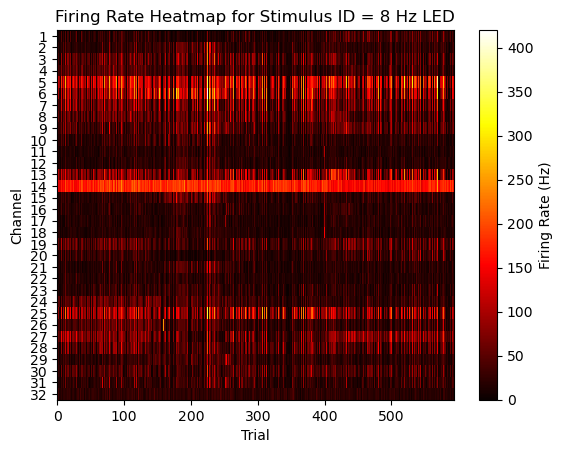

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def calculate_firing_rates(recording_name, recording_results_df, stimulation_data_df, n_channels):
    # Get the mua_data_path for the current recording to get the spike_data_path where the spike times are stored
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Construct the spike_data_path from the mua_data_path
    spike_data_path = mua_data_path.replace('_MUA.npy', '_spike_times.npy')
    
    # Step 1: Identify the time windows for stimulus_id = 8, which is an 8Hz signal 
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == 8)
    ]
    
    # Step 2: Load the corresponding spike times
    spike_data = np.load(spike_data_path, allow_pickle=True)
    spike_times = spike_data['time']
    spike_channels = spike_data['channel']
    
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]

    # Step 3 & 4: Calculate and aggregate the firing rates
    firing_rates = np.full((n_channels, len(stim_data)), np.nan) # Initialize with NaNs 

    for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
        for ch in good_channels:
            # Find spikes in the current channel and time window
            condition = (spike_channels == ch) & (spike_times >= onset) & (spike_times <= offset)
            spikes_in_window = spike_times[np.where(condition)]
            
            # Calculate the firing rate
            firing_rate = len(spikes_in_window) / (offset - onset)
            firing_rates[ch, i] = firing_rate
    
    # Step 5: Plotting the heatmap
    plt.imshow(firing_rates, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar(label='Firing Rate (Hz)')
    plt.ylabel('Channel')
    plt.xlabel('Trial')
    plt.title('Firing Rate Heatmap for Stimulus ID = 8 Hz LED')
    plt.yticks(range(n_channels), range(1, n_channels+1))  # Label y-axis with channel numbers
    plt.show()
    
calculate_firing_rates('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

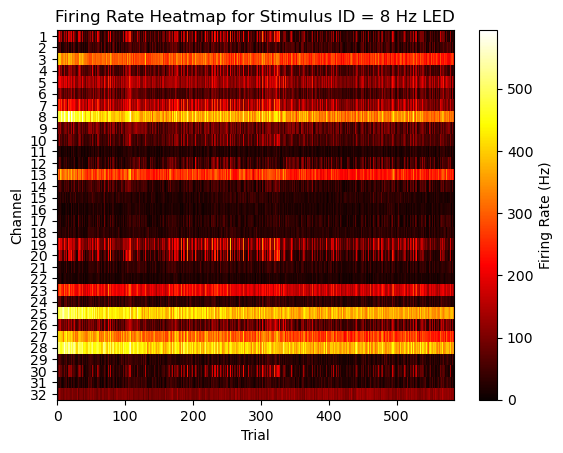

In [27]:
calculate_firing_rates('lmc_ch_1_3094_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

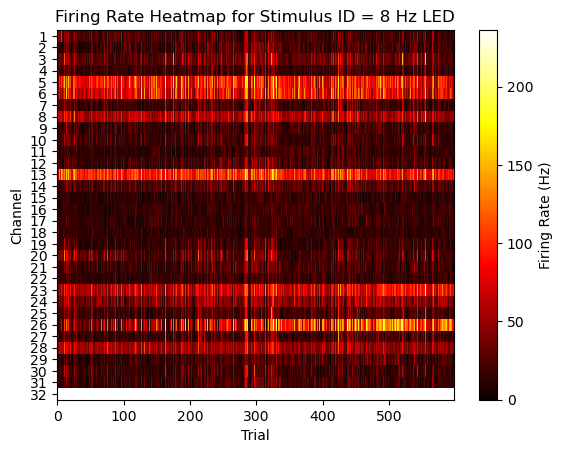

In [28]:
calculate_firing_rates('lmc_ch_1_3094_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

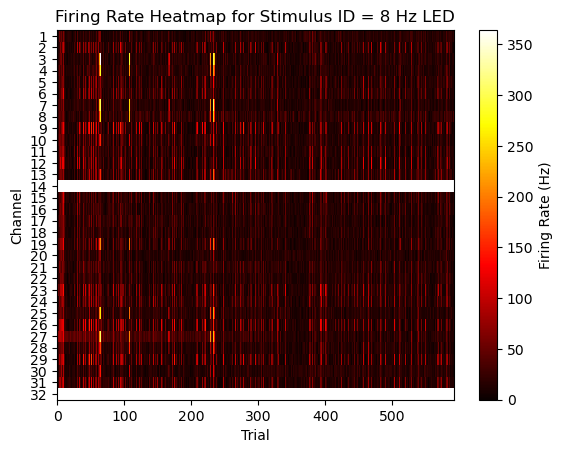

In [25]:
calculate_firing_rates('lmc_noch_1_3096_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

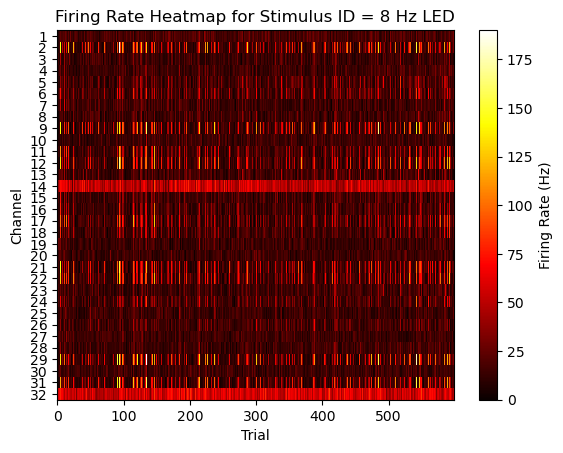

In [26]:
calculate_firing_rates('lmc_noch_1_3096_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

In [29]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def estimate_instantaneous_firing_rate(recording_name, recording_results_df, n_channels, bin_size=0.001, window_length=0.05, window_sd=0.005):
    """
    Estimate the instantaneous firing rate by convolving the spike time series with a Gaussian window.

    Parameters:
    - recording_name (str): The name of the recording to process.
    - recording_results_df (pd.DataFrame): The data frame containing the recording results.
    - n_channels (int): The number of channels in the recording.
    - bin_size (float): The bin size for discretizing the spike times, in seconds. Default is 1 ms (0.001 s).
    - window_length (float): The length of the Gaussian window in seconds. Default is 50 ms (0.05 s).
    - window_sd (float): The standard deviation of the Gaussian window in seconds. Default is 5 ms (0.005 s).
    
    Returns:
    - firing_rate_estimates (ndarray): A 2D array where each row represents a channel and each column represents a time bin. The values represent the estimated firing rates in Hz.
    """

    # Get the mua_data_path for the current recording to get the spike_data_path where the spike times are stored
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Construct the spike_data_path from the mua_data_path
    spike_data_path = mua_data_path.replace('_MUA.npy', '_spike_times.npy')
    
    # Step 1: Load the spike data
    spike_data = np.load(spike_data_path, allow_pickle=True)
    spike_times = spike_data['time']
    spike_channels = spike_data['channel']

    # Step 2: Determine the duration from the MUA data
    mua_data = np.load(mua_data_path)
    duration = mua_data.shape[0] / 10000  # Convert number of samples to seconds (assuming 10 kHz sampling rate)

    # Step 3: Create a time vector with bins
    time_vector = np.arange(0, duration, bin_size)

    # Step 4: Create a spike train matrix with each row representing a channel and each column representing a time bin
    spike_trains = np.zeros((n_channels, len(time_vector) - 1))

    for ch in range(n_channels):
        spike_times_ch = spike_times[spike_channels == ch]
        spike_trains[ch, :] = np.histogram(spike_times_ch, bins=time_vector)[0]

    # Step 5: Convolve the spike train with a Gaussian window to estimate the instantaneous firing rate
    window_length_bins = int(window_length / bin_size)  # Convert window length from seconds to number of bins
    window_sd_bins = window_sd / bin_size  # Convert window SD from seconds to number of bins
    firing_rate_estimates = np.zeros_like(spike_trains)

    for ch in range(n_channels):
        firing_rate_estimates[ch, :] = gaussian_filter1d(spike_trains[ch, :], sigma=window_sd_bins)

    return firing_rate_estimates

#run the function
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.n_channels)

In [ ]:
# Plot the heatmap
plt.imshow(firing_rate_estimates, aspect='auto', cmap='hot', interpolation='nearest', extent=[0, firing_rate_estimates.shape[1], 0, firing_rate_estimates.shape[0]])
plt.colorbar(label='Firing Rate (Hz)')
plt.ylabel('Channel')
plt.xlabel('Time (bins)')
plt.title('Instantaneous Firing Rate')
plt.show()

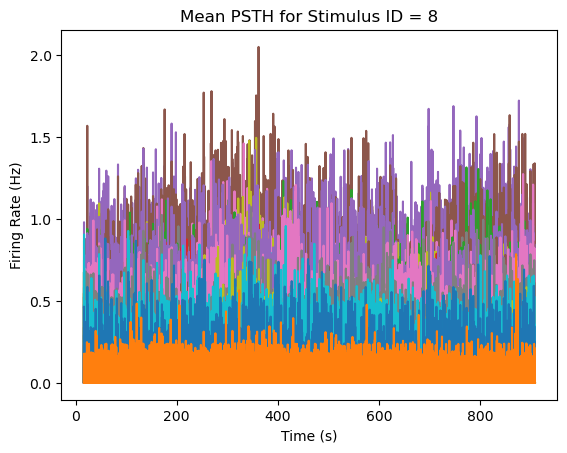

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_psth(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, stim_id, bin_size=0.001):
    
    # Get the mua_data_path for the current recording to get the spike_data_path where the spike times are stored
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Construct the spike_data_path from the mua_data_path
    spike_data_path = mua_data_path.replace('_MUA.npy', '_spike_times.npy')
    
    # Step 1: Identify the time windows for the specified stimulus_id
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == stim_id)
    ]
    
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]

    # Find the minimum onset and maximum offset times to get a common time window for all trials
    min_onset = stim_data['onset_times'].min() - 0.5  # 500 ms before the minimum onset
    max_offset = stim_data['offset_times'].max() + 0.5  # 500 ms after the maximum offset

    # Find the bins corresponding to the common time window
    start_bin = int(min_onset / bin_size)
    end_bin = int(max_offset / bin_size)

    # Initialize arrays to accumulate the sums and counts for each bin
    sum_psth = np.zeros((n_channels, end_bin - start_bin))
    count_psth = np.zeros((n_channels, end_bin - start_bin))

    # Loop through each trial to calculate the PSTH
    for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
        # Find the bins corresponding to the current time window
        trial_start_bin = int((onset - 0.5) / bin_size)
        trial_end_bin = int((offset + 0.5) / bin_size)

        # Add the firing rate estimates to the sum and update the count in the relevant bins
        sum_psth[:, trial_start_bin - start_bin : trial_end_bin - start_bin] += firing_rate_estimates[:, trial_start_bin:trial_end_bin]
        count_psth[:, trial_start_bin - start_bin : trial_end_bin - start_bin] += 1
    
    # Calculate the mean PSTH by dividing the sum by the count
    mean_psth = np.divide(sum_psth, count_psth, where=(count_psth!=0))

    # Plotting the mean PSTH for each channel
    time_bins = np.linspace(min_onset, max_offset, end_bin - start_bin)
    plt.figure()
    for ch in good_channels:
        plt.plot(time_bins, mean_psth[ch, :])
    
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title(f'Mean PSTH for Stimulus ID = {stim_id}')
    plt.show()

#first get the firing rate estimates for the recording name
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.n_channels)
#run the function 
calculate_psth('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

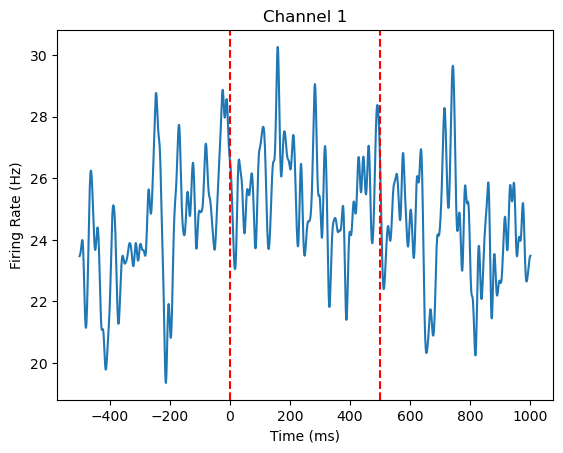

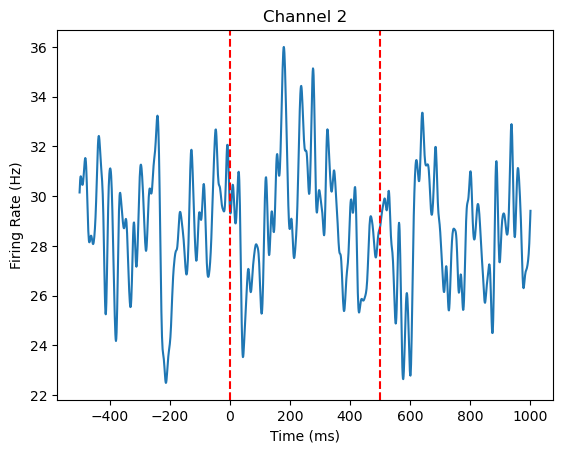

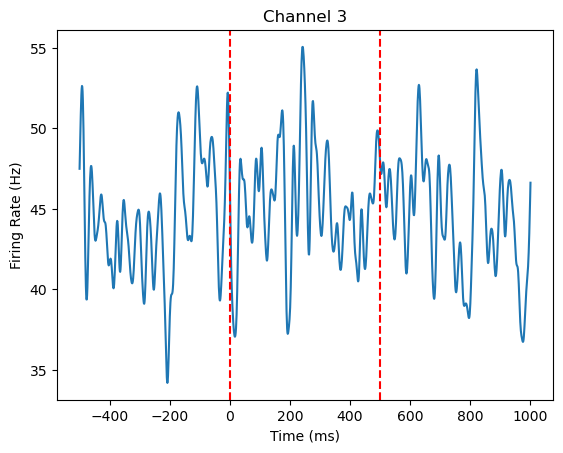

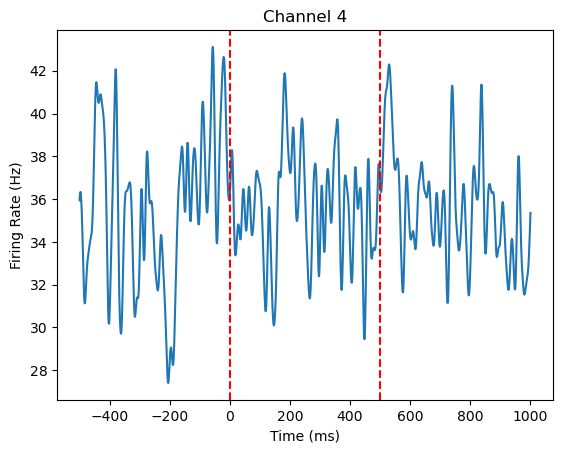

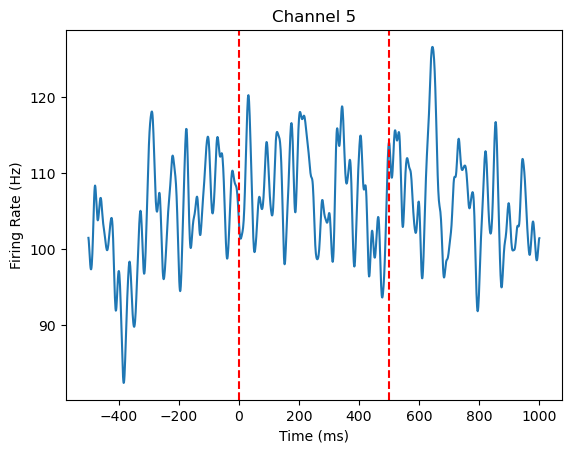

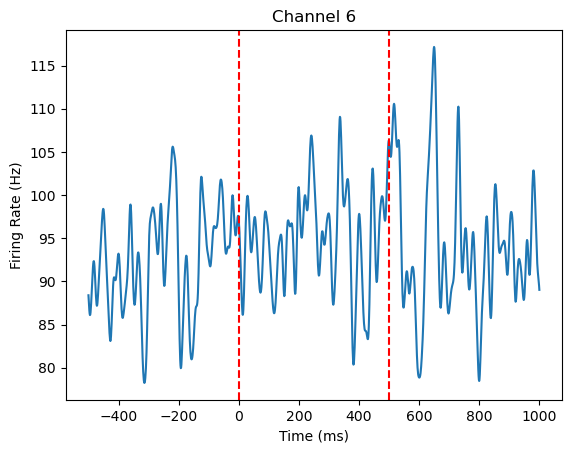

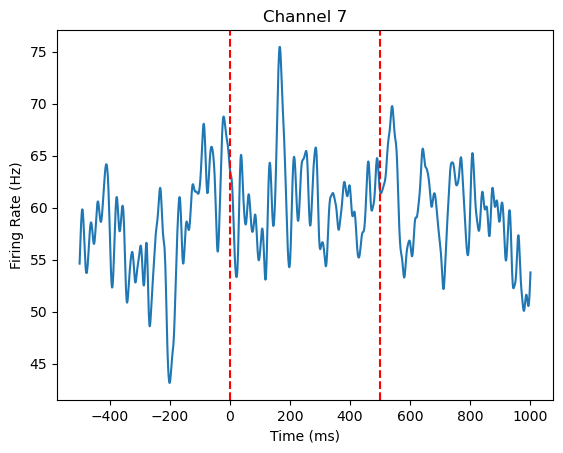

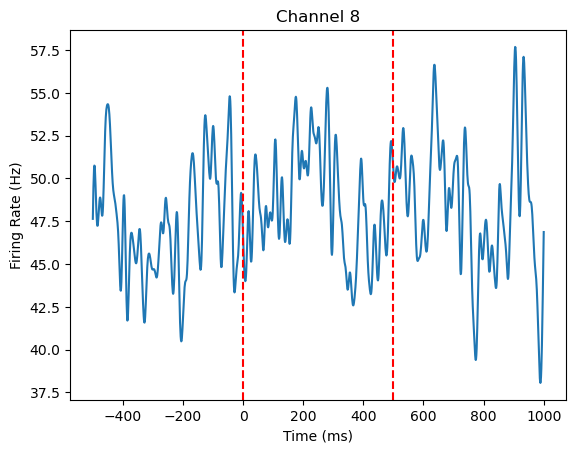

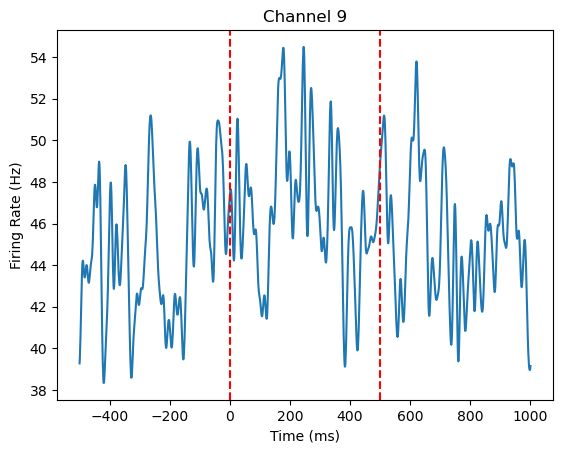

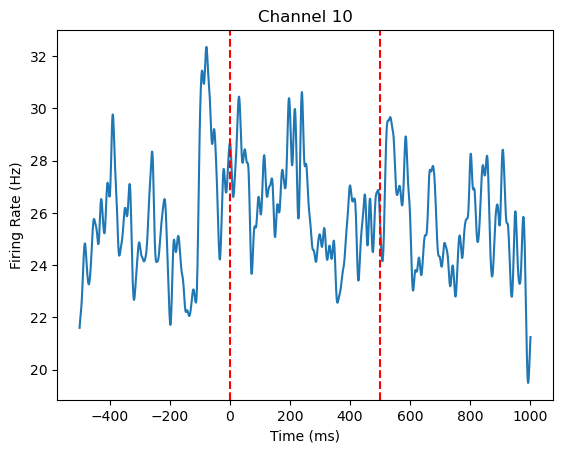

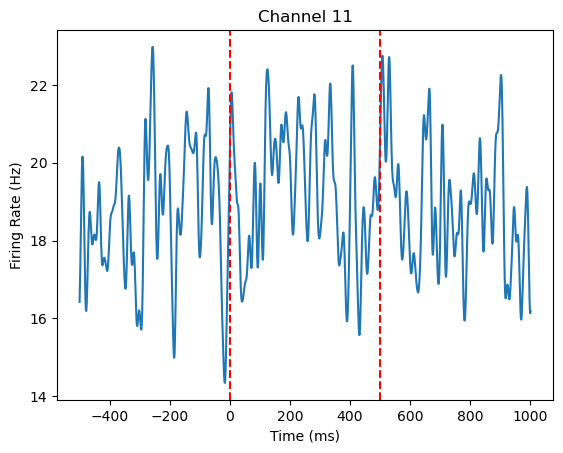

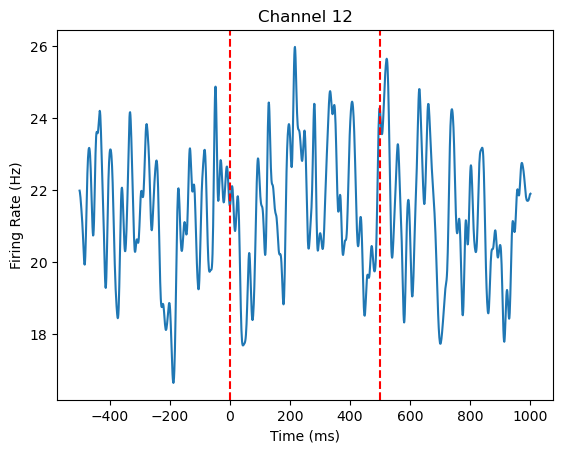

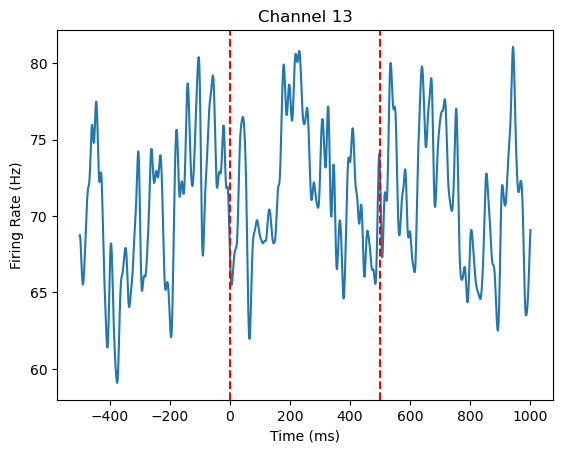

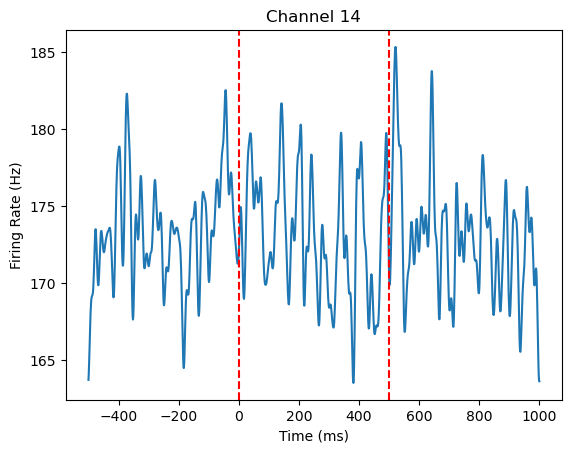

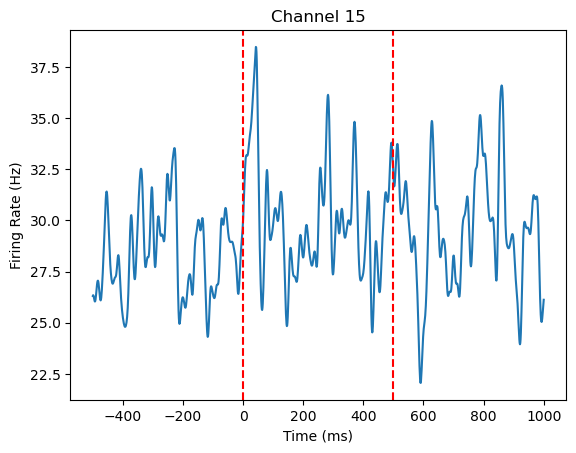

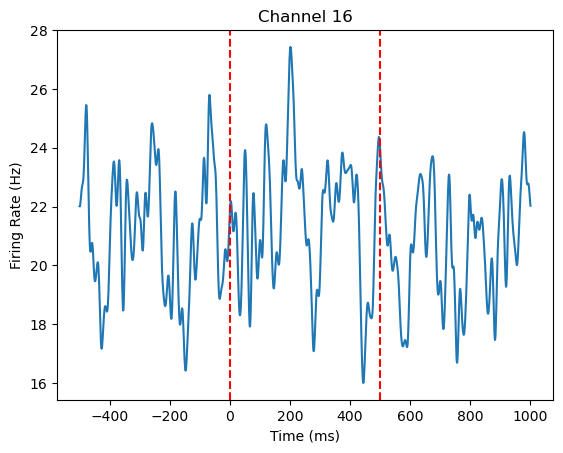

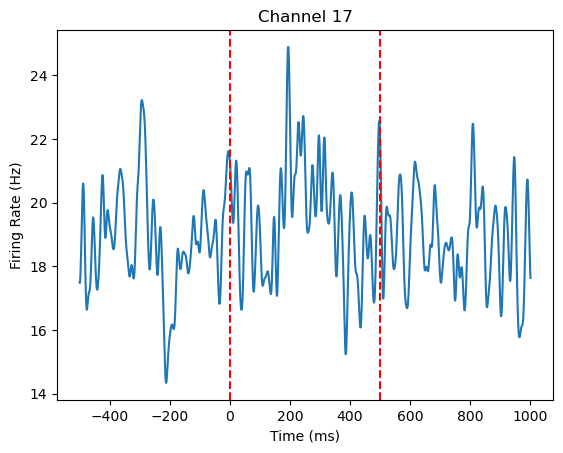

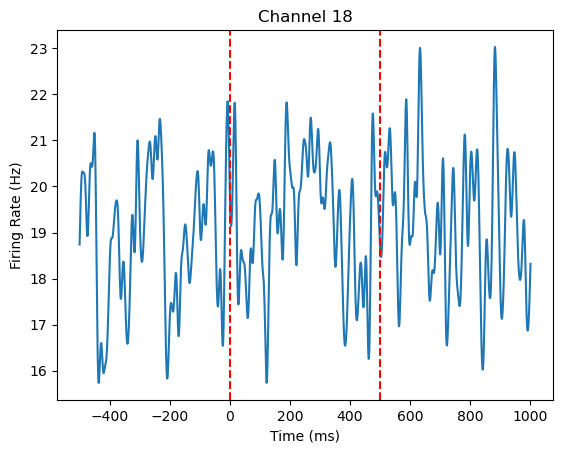

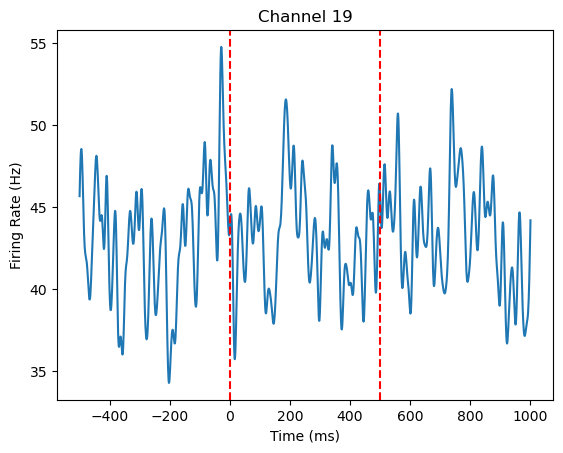

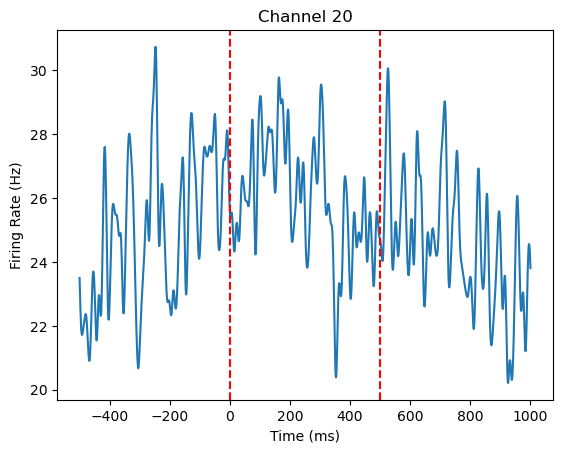

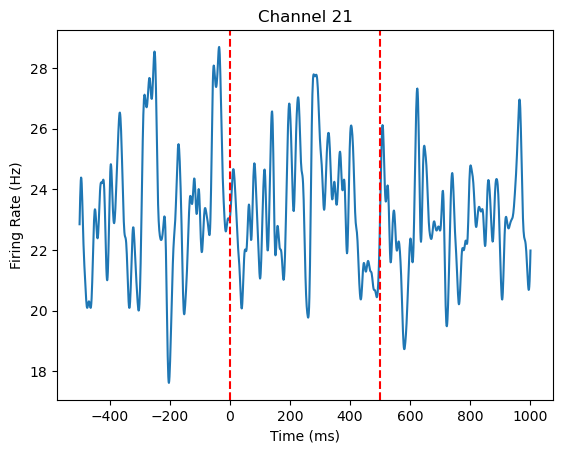

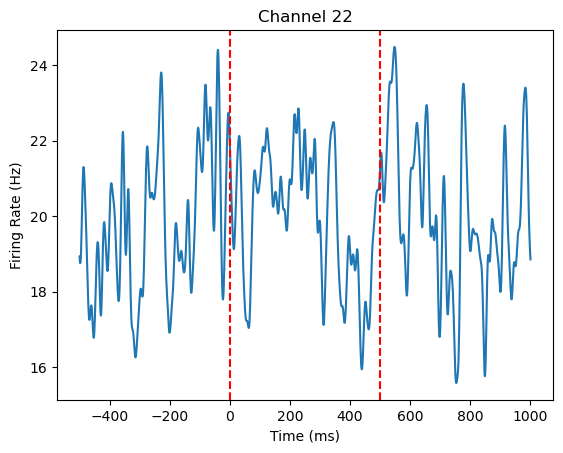

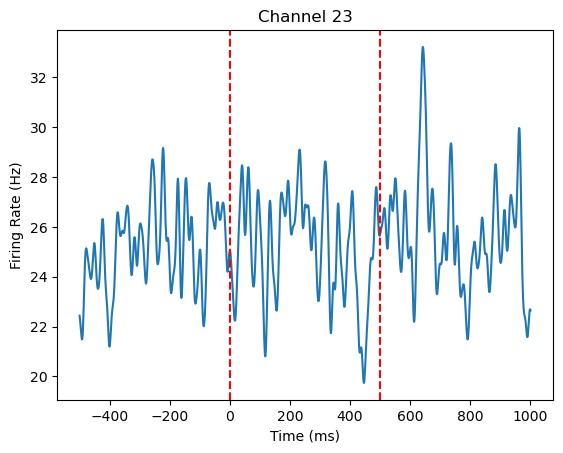

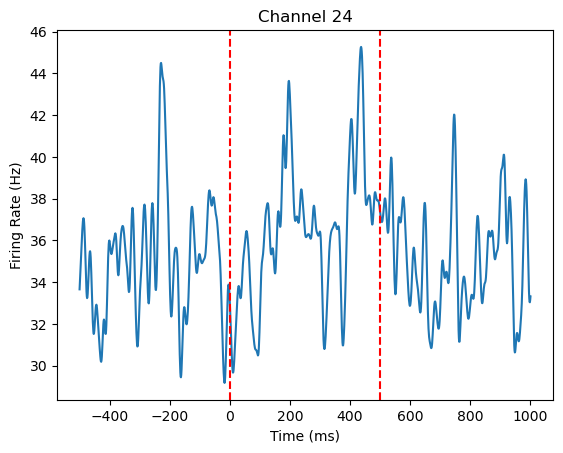

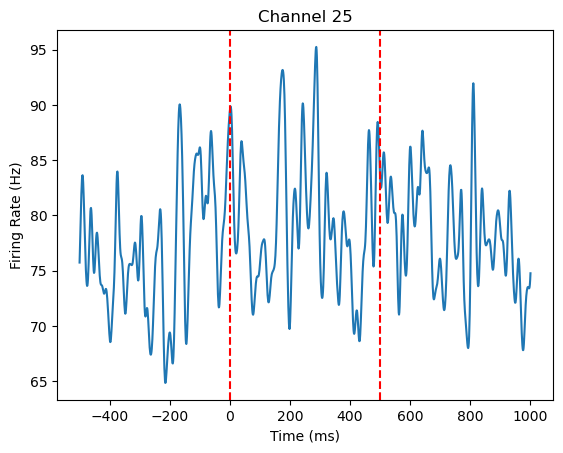

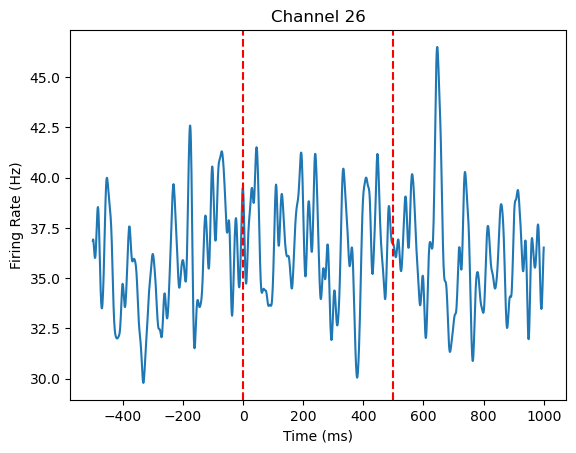

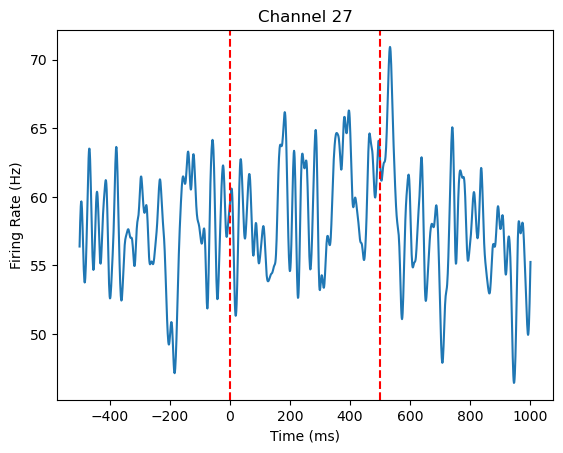

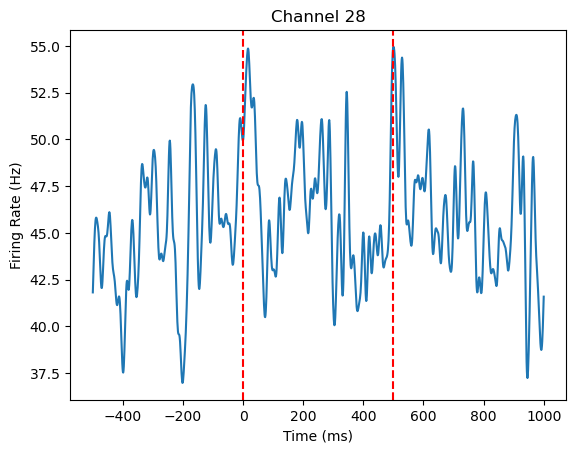

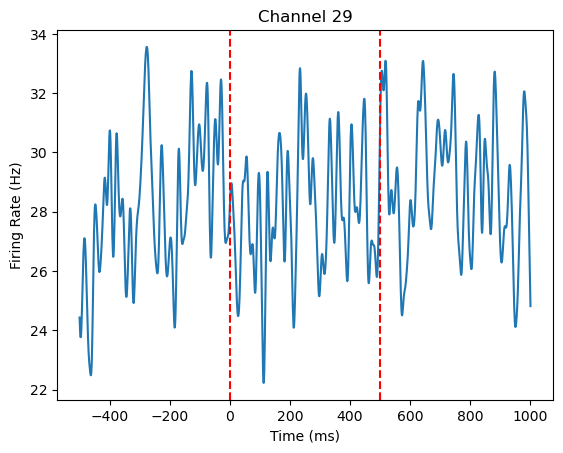

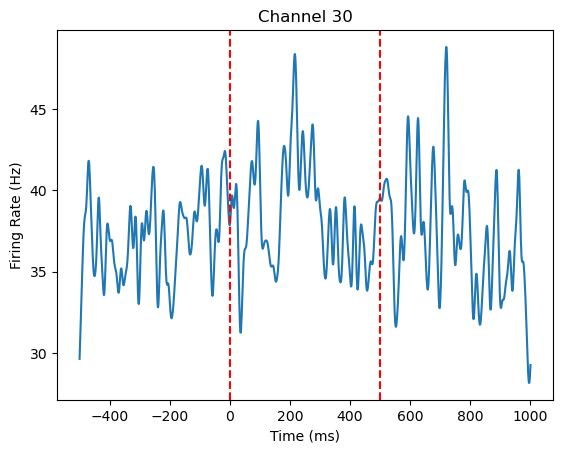

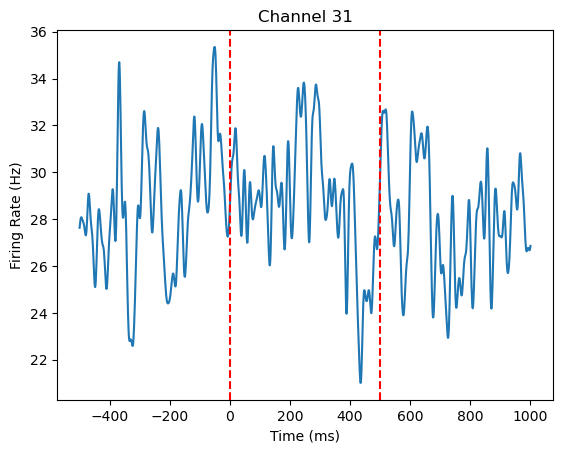

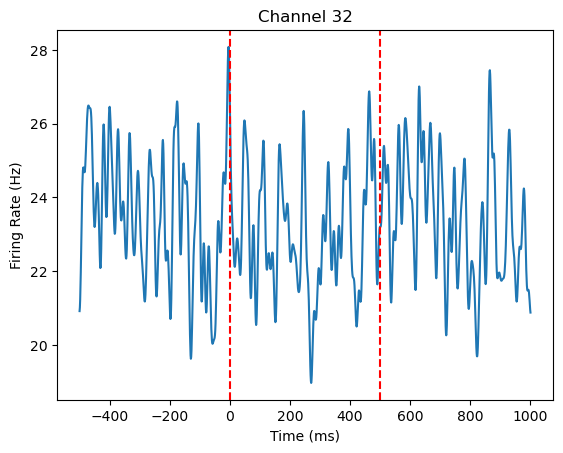

In [38]:
def calculate_psth(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, stim_id=1, bin_size=0.001):
    # Get the mua_data_path for the current recording
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Step 1: Identify the time windows for the specified stimulus_id
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == stim_id)
    ]
    
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]

    # Exclude noisy channels from good channels
    good_channels = [ch for ch in good_channels if ch not in noisy_channels]

    # Step 2 & 3: Aggregate the PSTH data
    psth_duration_in_s = 1.5  # PSTH duration in seconds (1500 ms)
    num_bins = int(psth_duration_in_s / bin_size)
    sum_psth = np.zeros((n_channels, num_bins))  # Initialize with zeros
    count_psth = np.zeros((n_channels, num_bins))  # Initialize with zeros

    for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
        for ch in good_channels:
            # Find the bins corresponding to the current time window (from -500ms to +1000ms relative to the onset)
            start_bin = int((onset - 0.5) / bin_size)
            end_bin = int((onset + 1.0) / bin_size)
            
            # within your loop where you extract trial_psth
            trial_psth = firing_rate_estimates[ch, start_bin:end_bin][:1500]
            
            #accumulate the sum and update the count in the relevant bins
            try: 
                sum_psth[ch, :] += np.nan_to_num(trial_psth)
                count_psth[ch, :] += np.isfinite(trial_psth)
            except ValueError: 
                # If lengths are mismatched, extend trial_psth with its last value
                if len(trial_psth) == len(sum_psth[ch, :]) - 1:
                    trial_psth = np.append(trial_psth, trial_psth[-1])
                    sum_psth[ch, :] += np.nan_to_num(trial_psth)
                    count_psth[ch, :] += np.isfinite(trial_psth)
                else:
                    print("Unexpected mismatch in lengths")
 
    # Calculate the mean PSTH by dividing the sum by the count
    mean_psth = np.divide(sum_psth, count_psth, where=(count_psth!=0))
    
    # Convert firing rate from spikes per bin to spikes per second (Hz)
    mean_psth /= bin_size

    # Create a time axis that spans from -500 ms to +1000 ms
    time_axis = np.linspace(-500, 1000, num_bins)

    # Step 4: Plotting the mean PSTH for each channel
    plt.figure()
    for ch in range(n_channels):
        plt.plot(time_axis, mean_psth[ch, :])
        plt.xlabel('Time (ms)')
        plt.ylabel('Firing Rate (Hz)')
        plt.title(f'Channel {ch+1}')
        plt.axvline(x=0, color='r', linestyle='--')  # Mark stimulus onset
        plt.axvline(x=500, color='r', linestyle='--')  # Mark stimulus offset
        plt.show()

#run the function with the firing rate estimates
calculate_psth('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)